In [1]:
import scipy as sp
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import time
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

%matplotlib inline

## CUDA code

In [2]:
mod = SourceModule("""
#include <curand.h>
#include <curand_kernel.h>

extern "C" {
    __global__ void init( unsigned long long int* seed, curandState * state){
        int id = threadIdx.x;
        curand_init(*seed, id, 0, &state[id]);
    }
    
    __device__ float pi(float &x, float *pars){
      return expf(-powf(fabsf(x*pars[2]), pars[1]));
    }
    
    __device__ float f(float &x, float *pars){
      return cosf(x*pars[0]);
    }
    
    __global__  void mcmc(curandState* states, unsigned int * num_samples, float * Pars, int * npar, 
                          float * Sigma, float * result){
        int id            = threadIdx.x;
        curandState state = states[id];
        unsigned int N    = *num_samples;
        float sigma       = *Sigma;
        float *pars       = new float[*npar];
        memcpy(pars, &Pars[*npar*id], *npar*sizeof(float));
        
        float xi = curand_uniform(&state);
        float xg = 0.0;
        float s  = 0.0;
        for(unsigned int i=0;i<N;i++){
            xg = sigma*curand_normal(&state)+xi;
            if (curand_uniform(&state)<pi(xg, pars)/pi(xi, pars)){
              xi = xg;
            }
            s += f(xi, pars);
        }
        result[id] = s/float(N);
        delete pars;
    }
}
""", no_extern_c=True)

## Getting init and mcmc CUDA functions

In [3]:
init = mod.get_function("init")
mcmc = mod.get_function("mcmc")

## Constants

In [21]:
N      = 200        # r parameter range divided to N part
rrange = [-10,10]   # r parameter range, r Levy parameter
alpha  = 0.7        # Levy parameter  
R      = 3          # Levy parameter

In [22]:
num_samples = np.int32(1000000)                  # MCMC path length
npar        = np.int32(3)                        # number of parameters: r, alpha, R
proposal_sd = np.float32(1.0)                    # xnew = normal(xi, proposal_sigma)
res         = np.array([0]*N, dtype=np.float32)  # array for result

## Initialize curand

In [23]:
sizeof_curandState = pycuda.characterize.sizeof('curandState', '#include <curand_kernel.h>')

In [24]:
rng_states = cuda.mem_alloc(N*sizeof_curandState);  #lot of start states, so the different threads rand number won't correlate

In [25]:
init(cuda.In(np.int64(time.time()*100)), rng_states, block=(N,1,1))

## Create r parameter range

In [26]:
def create_pars(rmin, rmax, n, alpha, R):
    return np.reshape(np.array(list(map(lambda x: [x, alpha, R], np.linspace(rmin,rmax,n))), dtype=np.float32), n*3)

In [27]:
pars = create_pars(rrange[0], rrange[1], N, alpha, R)

## Run MCMC on CUDA

In [28]:
mcmc(rng_states, cuda.In(num_samples), cuda.In(pars), cuda.In(npar), cuda.In(proposal_sd), cuda.Out(res),
     block=(N,1,1),time_kernel=True)

1.3495888710021973

#### 1.35s until 200 MCMC completed (every MCMC had 1000000 length path)

## Calculate the normalization factor of p(x)

In [29]:
def p(x, alpha, R):
    return np.exp(-np.power(np.linalg.norm(x)*R, alpha) )

C = integrate.quad(p, -np.inf, np.inf, args=(0.7, 3))[0]

## Scale the result

In [30]:
res = C*res/(2*np.pi)

## Connecting to R, link dstable R function from stabledist package to python

In [31]:
r  = robjects.r
cf = robjects.FloatVector
libPaths=r[".libPaths"]
libPaths(robjects.StrVector([libPaths()[0], libPaths()[1], "D:/Documents/R/win-library/3.3"]))
importr("stabledist")
levy     = r["dstable"]

## Plot the result

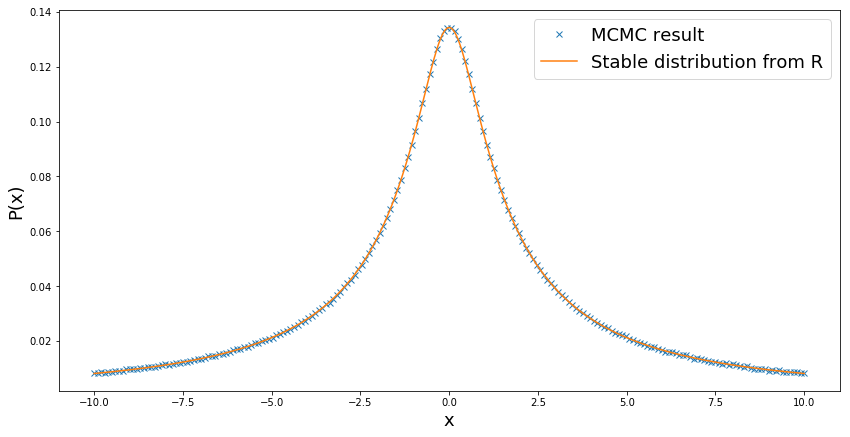

In [32]:
plt.figure(0,(14,7))
plt.xlabel("x", fontsize=18)
plt.ylabel("P(x)", fontsize=18)
plt.plot(np.linspace(-10, 10, N),res, 'x', label="MCMC result")
x2 = np.linspace(-10,10,1000)
y2 = np.array(levy(cf(x2), alpha=0.7, gamma=3, beta=0))
plt.plot(x2,y2, label="Stable distribution from R")
plt.legend(fontsize=18)